<a href="https://colab.research.google.com/github/azamshaikh1103/Property-Price_UsingML/blob/main/Experiment_3_AI_for_medical_diagnosis_based_on_MRI_X_ray_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle API

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.14G/1.14G [00:17<00:00, 105MB/s] 
100% 1.14G/1.14G [00:17<00:00, 71.8MB/s]


In [ ]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 1 Set up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Define Constants

In [ ]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [ ]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


# 2 Preparing Data

## 2.2 Image Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,

                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [ ]:
type(train)

keras.preprocessing.image.DirectoryIterator

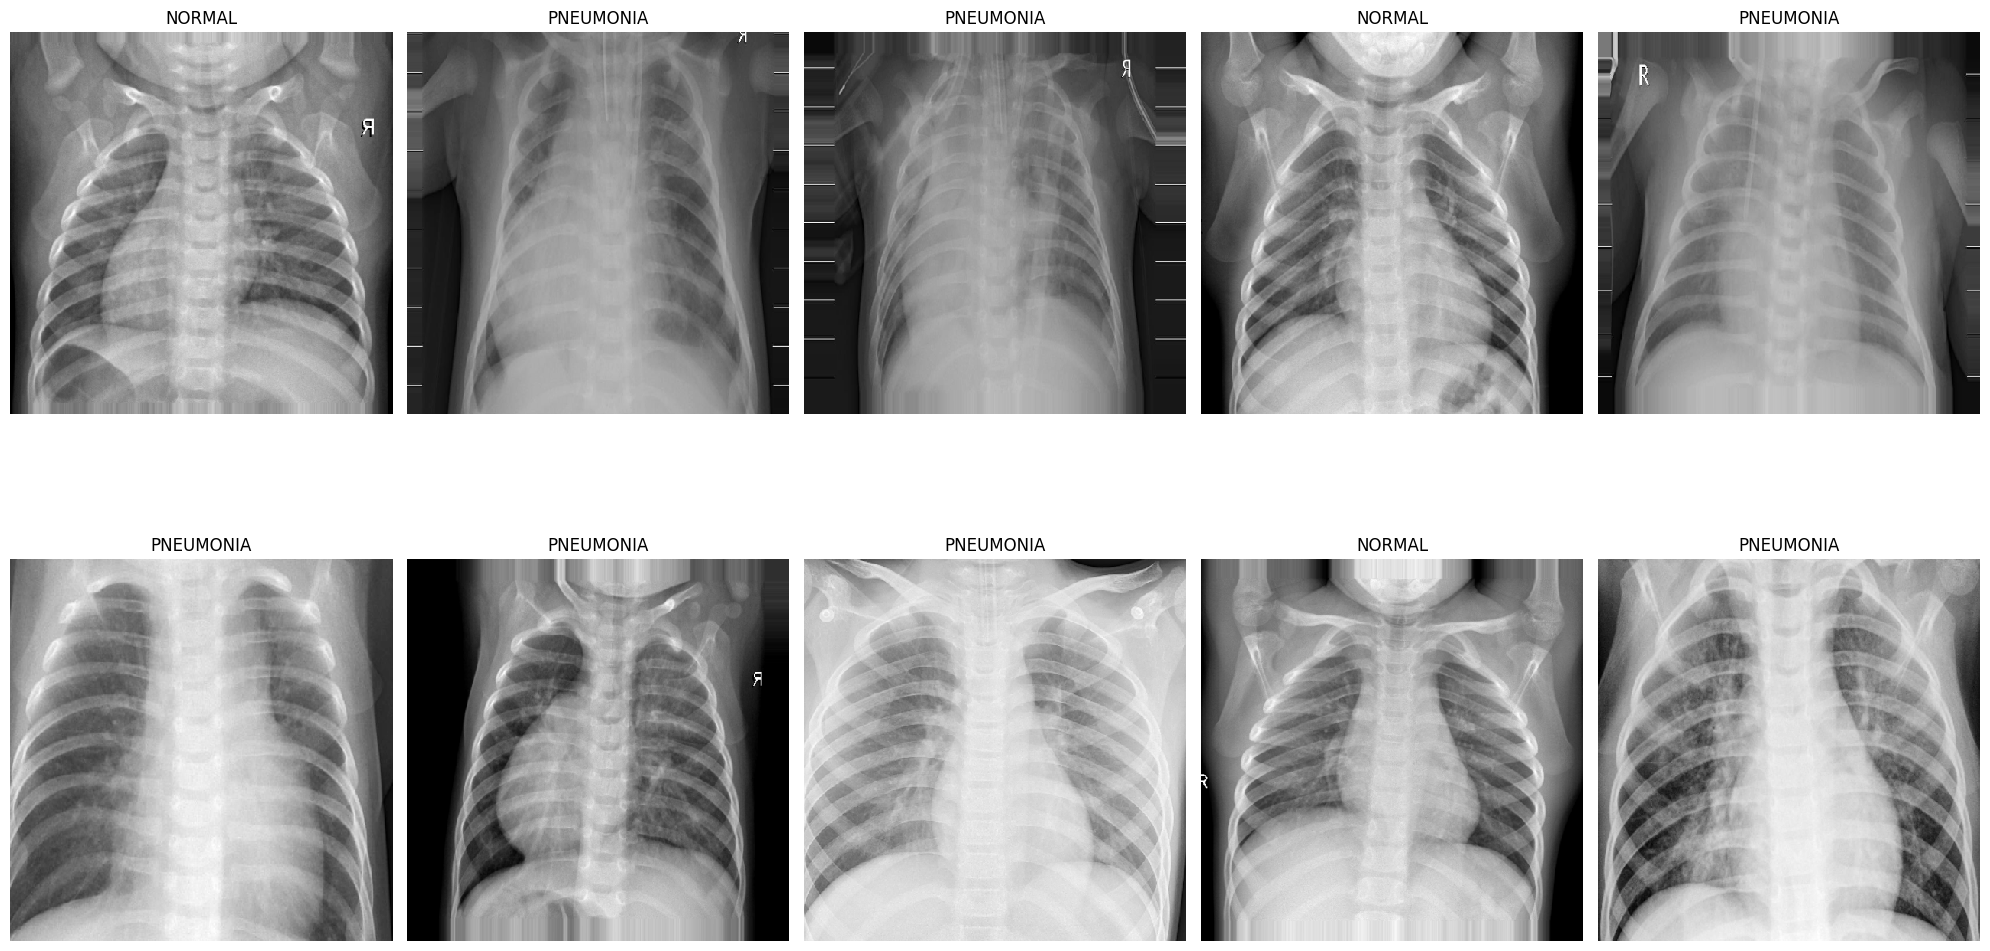

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

In [ ]:
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening

rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.2, # Randomly zoom image
width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
horizontal_flip = True,  # randomly flip images
vertical_flip=False,# randomly flip images
shear_range=0.2,
brightness_range=(1.2, 1.5)

# 3 Tensorflow - Keras

In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 3.1 Convolutional Neural Network Model

In [ ]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

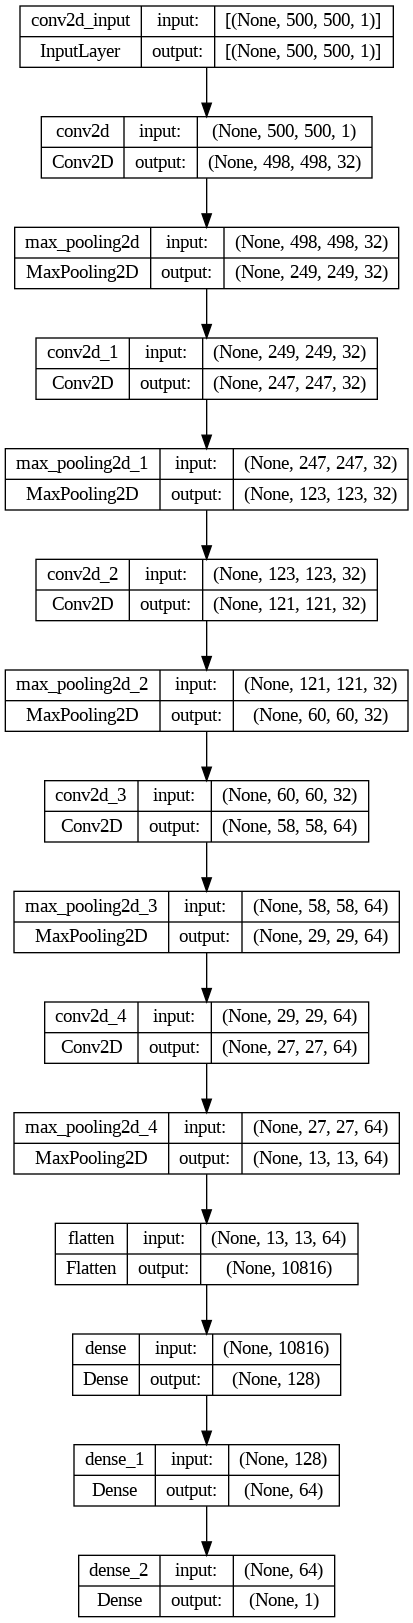

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 3.2 Fit Model

In [ ]:
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes
                                    )
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
cnn.fit(train,epochs=1, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

KeyboardInterrupt: ignored

In [ ]:
fp = "/content/cnn_pneu_vamp_model.h5"
#cnn.save(fp)

In [ ]:
cnn = load_model(fp)

In [ ]:
#cnn.predict_segmentation()
preds=cnn.predict
pred=np.argmax(preds)
print(preds)
print(pred)

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7fc4ffc6a440>>
0


##3.3 Evaluation

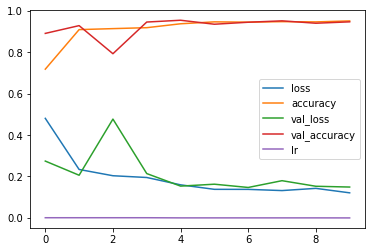

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 85s 2s/step - loss: 0.3609 - accuracy: 0.9103
The testing accuracy is : 91.02563858032227 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 75s 2s/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

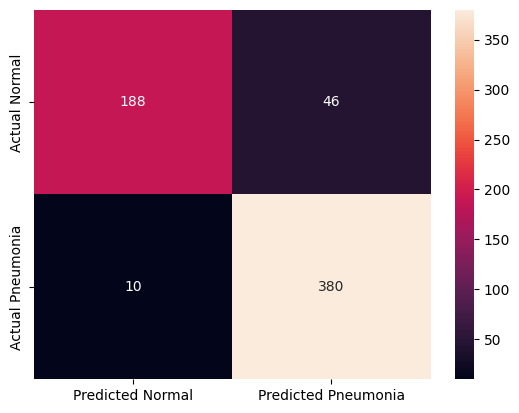

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.95      0.80      0.87       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


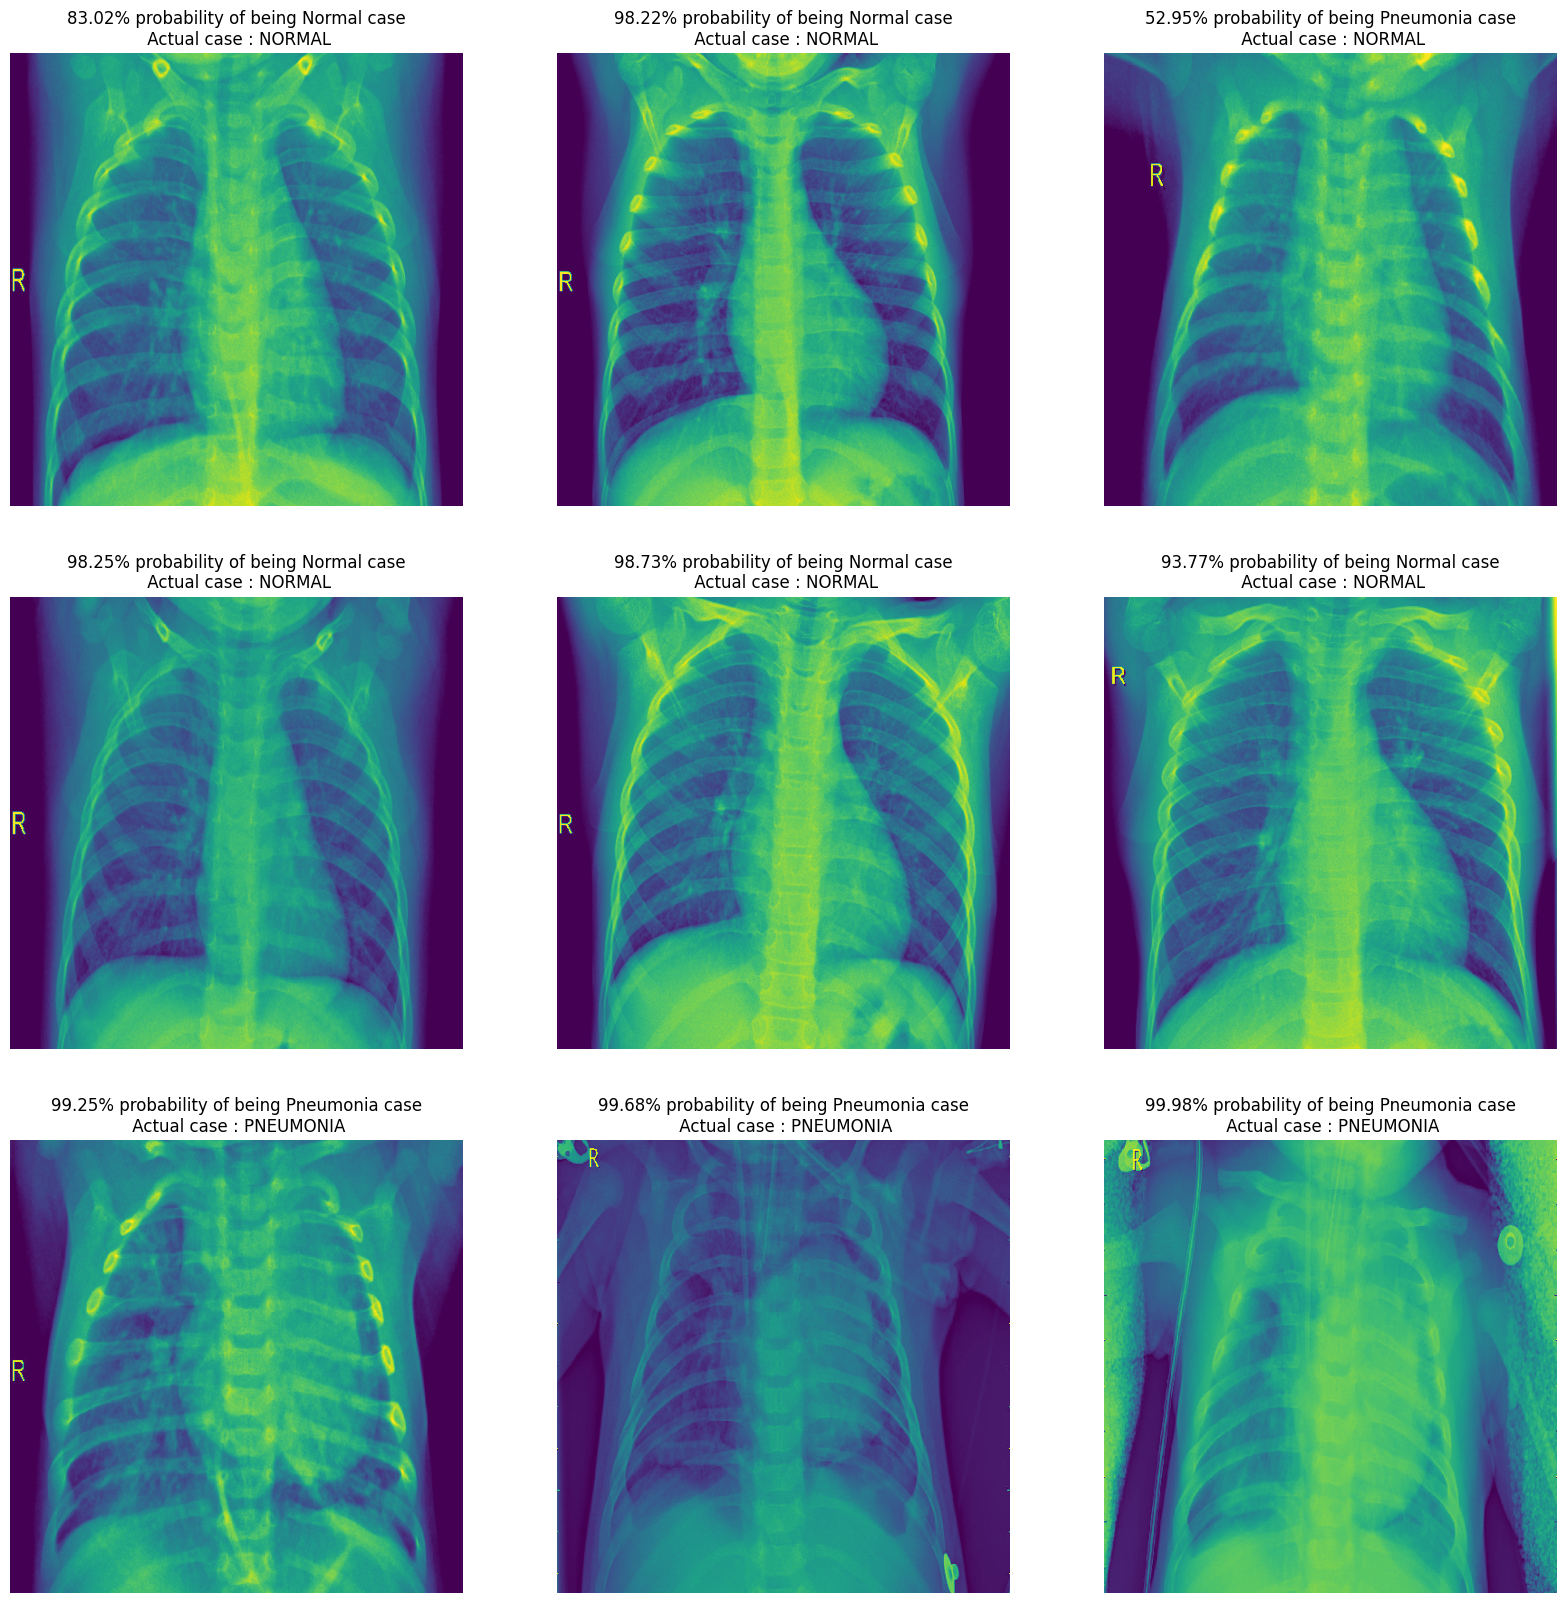

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))



  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()

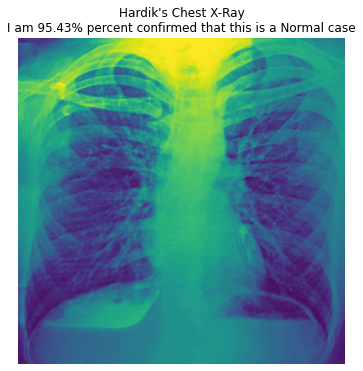

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/drive/My Drive/unsegregated /IMG_20201023_204205928~2.jpg'

from tensorflow.keras.preprocessing import image

hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

#predict
hardik_preds= cnn.predict(pp_hardik_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))


plt.title("Hardik's Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

# Run streamlit app from a Google Colab Notebook
> Created by [Manuel Romero](https://twitter.com/mrm8488)

In [ ]:
!pip install -q streamlit

     |████████████████████████████████| 7.4MB 4.8MB/s 
     |████████████████████████████████| 112kB 42.7MB/s 
     |████████████████████████████████| 163kB 39.5MB/s 
     |████████████████████████████████| 4.5MB 41.6MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 122kB 45.5MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.


In [ ]:
!pip install h5py

Reset the execution environment after streamlit installation

## Download a streamlit app example

This example comes from [How to Build a Simple Machine Learning Web App in Python](https://www.youtube.com/watch?v=8M20LyCZDOY) and it will create a **Simple Iris Flower Prediction App**

In [ ]:
!wget https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py

--2020-12-02 19:25:22--  https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [text/plain]
Saving to: ‘webapp.py’

webapp.py           100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-12-02 19:25:22 (67.2 MB/s) - ‘webapp.py’ saved [1362/1362]



## OR

## Install ngrok

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2020-12-03 16:39:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.154.11, 34.198.255.223, 34.232.108.170, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.154.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  36.8MB/s    in 0.4s    

2020-12-03 16:39:32 (36.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
%%writefile webapp.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import tensorflow as tf

from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)

def loading_model():
  fp = "cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()
st.write("""
# X-Ray Classification (Pneumonia/Normal)
""")






temp = st.file_uploader("Upload X-Ray Image")

buffer = temp
temp_file = NamedTemporaryFile(delete=False)
if buffer:
    temp_file.write(buffer.getvalue())
    st.write(image.load_img(temp_file.name))


if buffer is None:
  st.text("Oops! that doesn't look like an image. Try again.")

else:



  hardik_img = image.load_img(temp_file.name, target_size=(500, 500),color_mode='grayscale')

  # Preprocessing the image
  pp_hardik_img = image.img_to_array(hardik_img)
  pp_hardik_img = pp_hardik_img/255
  pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

  #predict
  hardik_preds= cnn.predict(pp_hardik_img)
  if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

  else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))

  st.success(out)

  image = Image.open(temp)
  st.image(image,use_column_width=True)








Writing webapp.py


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://bd074ed7a4ec.ngrok.io


In [ ]:
!streamlit run /content/webapp.py

2020-12-03 16:45:09.369931: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.70.193.158:8501

2020-12-03 16:45:10.837424: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-03 16:45:10.847553: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-03 16:45:10.847609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1e3875f738b4): /proc/driver/nvidia/version does not exist
2020-12-03 16:45:10.854335: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-12-03 16:45:10.854580: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1a

[![ko-fi](https://www.ko-fi.com/img/githubbutton_sm.svg)](https://ko-fi.com/Y8Y3VYYE)